Linear Regression MSE (Team Value): 3908664677782492.5, R2: 0.9301464937121706
Ridge MSE (Team Value): 3908609049445812.5, R2: 0.9301474878712215
Lasso MSE (Team Value): 3908664663463154.5, R2: 0.930146493968078
XGBoost MSE (Team Value): 3278350450050452.5, R2: 0.9414111230676793
Random Forest MSE (Team Value): 2992227077592721.5, R2: 0.946524562680619
KNN MSE (Team Value): 2344368729395771.0, R2: 0.9581027309119938
Cross-validation MSE (Team Value with KNN): 7776430086219480.0


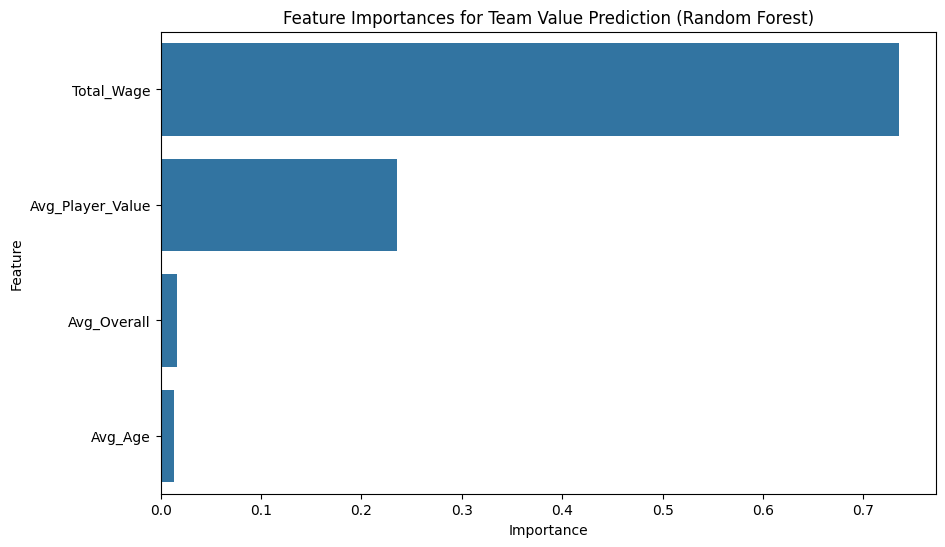

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

# Load the cleaned data
df = pd.read_csv('../Dataset/Cleaned/combinedCleanedData_20240709_145255.csv')

# Aggregate data by team
team_df = df.groupby('Club').agg({
    'Value': 'mean',
    'Overall': 'mean',
    'Wage': 'sum',
    'Age': 'mean'
}).reset_index()

team_df.rename(columns={
    'Value': 'Avg_Player_Value',
    'Overall': 'Avg_Overall',
    'Wage': 'Total_Wage',
    'Age': 'Avg_Age'
}, inplace=True)

# Define features and target for team value prediction
features_team_value = ['Avg_Player_Value', 'Avg_Overall', 'Total_Wage', 'Avg_Age']
X_team_value = team_df[features_team_value]
y_team_value = df.groupby('Club')['Value'].sum()

# Split data
X_train_team, X_test_team, y_train_team, y_test_team = train_test_split(X_team_value, y_team_value, test_size=0.2, random_state=42)

# Create a pipeline
def create_pipeline(model):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

# Define models
models = {
    'Linear Regression': create_pipeline(LinearRegression()),
    'Ridge': create_pipeline(Ridge()),
    'Lasso': create_pipeline(Lasso()),
    'XGBoost': create_pipeline(XGBRegressor(random_state=42)),
    'Random Forest': create_pipeline(RandomForestRegressor(n_estimators=100, random_state=42)),
    'KNN': create_pipeline(KNeighborsRegressor(n_neighbors=5))
}

# Evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_team, y_train_team)
    y_pred = model.predict(X_test_team)
    mse = mean_squared_error(y_test_team, y_pred)
    r2 = r2_score(y_test_team, y_pred)
    results[name] = {'MSE': mse, 'R2': r2}
    print(f"{name} MSE (Team Value): {mse}, R2: {r2}")

# Select the best model based on MSE
best_model_name = min(results, key=lambda x: results[x]['MSE'])
best_model = models[best_model_name]

# Cross-validation for the best model
cv_scores = cross_val_score(best_model, X_team_value, y_team_value, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validation MSE (Team Value with {best_model_name}): {-cv_scores.mean()}")

# Use Random Forest to get feature importances
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_team, y_train_team)
importances = rf_model.feature_importances_
feature_names = X_team_value.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importances for Team Value Prediction (Random Forest)')
plt.show()
